In [5]:
import os
import math
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils_feature_engineering import *

In [6]:
path = r'D:\NEU\Năm 3\DATA PREP\PROJECT_DATAPREP\GITHUB REPO\dataset\dseb63_final_project_DP_dataset\\'
# train
application_train = pd.read_csv(path + 'dseb63_' + 'application_train.csv')
application_train.drop(columns='Unnamed: 0', inplace=True)
# test
application_test = pd.read_csv(path + 'dseb63_' + 'application_test.csv')
application_test.drop(columns='Unnamed: 0', inplace=True)

In [7]:
# Chỉ giữ lại cột SK_ID_CURR và biến target
# filter by tvt code
application_tvt_extend = pd.read_pickle(
    "application_tvt_extend.pkl", compression="bz2")
application_train_filtered = (application_tvt_extend.query("tvt_code == 'train'")
                              .merge(application_train[["SK_ID_CURR"]], on="SK_ID_CURR")
                              .drop(columns=["tvt_code"]))
application_train_filtered.head()

,SK_ID_CURR,TARGET
0,278621,0
1,139008,0
2,138348,0
3,53466,0
4,27272,0


In [8]:
# installments_payments 
installments_payments = pd.read_csv(path + 'dseb63_installments_payments.csv')
installments_payments.head()

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR
0,1054186,1.0,6,-1180.0,-1187.0,6948.360,6948.360,147397.0
1,2452854,1.0,21,-546.0,-552.0,11302.605,11302.605,147397.0
2,1054186,1.0,2,-1300.0,-1307.0,6948.360,6948.360,147397.0
3,1682318,1.0,2,-240.0,-243.0,7374.510,7374.510,147397.0
4,2452854,1.0,10,-876.0,-882.0,11302.605,11302.605,147397.0


Preprocessing

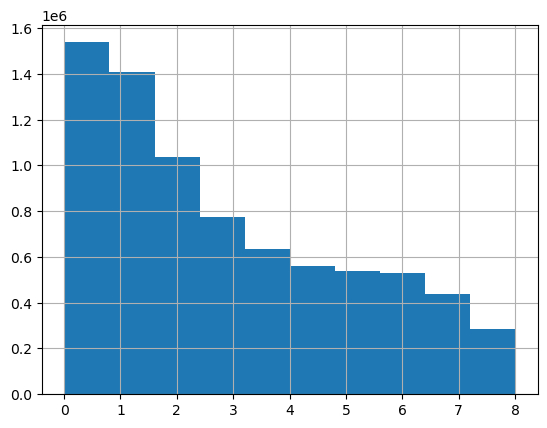

In [9]:
# Vẽ histogram của cột "DAYS_INSTALMENT" chia cho -365 để chuyển đổi đơn vị sang năm và đảo chiều dấu
(installments_payments["DAYS_INSTALMENT"] / -365).hist()
plt.show()


In [10]:
# chuyển đổi giá trị thành năm
installments_payments["DAYS_INSTALMENT_TO_YEARS"] = installments_payments["DAYS_INSTALMENT"] / -365
installments_payments.drop(columns=["DAYS_INSTALMENT"], inplace=True)

In [11]:
# Tính toán sự khác biệt giữa "AMT_PAYMENT" và "AMT_INSTALMENT" 

installments_payments["AMT_PAYMENT"].fillna(0, inplace=True)
installments_payments["diff_amount"] = installments_payments["AMT_PAYMENT"] - installments_payments["AMT_INSTALMENT"]

installments_payments["diff_amount"].describe()


count    7.744757e+06
mean     1.255704e+02
std      1.891506e+04
min     -2.424726e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.630909e+06
Name: diff_amount, dtype: float64

Numerical features

In [12]:
# get list numerical attributes
series_type = installments_payments.dtypes
ls_num = series_type[series_type == "int64"].index.tolist()
ls_num = [col for col in ls_num if col not in ["SK_ID_PREV", "SK_ID_CURR"]]
ls_num

['NUM_INSTALMENT_NUMBER']

In [13]:
# Tổng hợp dữ liệu từ cột "NUM_INSTALMENT_NUMBER" theo "SK_ID_CURR"
pdf_agg02 = agg_common_data(installments_payments[["SK_ID_CURR", "NUM_INSTALMENT_NUMBER"]], ["max", "min", "sum", "mean", "std"], main_key="SK_ID_CURR")

# Đánh giá đặc trưng 
eval_agg02 = feature_evaluate(application_train_filtered, pdf_agg02)


{'NUM_INSTALMENT_NUMBER': ['max', 'min', 'sum', 'mean', 'std']}

After agg: (180733, 5)


In [14]:
eval_agg02

,name,auc,corr,coverage
2,NUM_INSTALMENT_NUMBER_sum,0.510121,-0.018515,1.0000
3,NUM_INSTALMENT_NUMBER_mean,0.509592,-0.011153,1.0000
4,NUM_INSTALMENT_NUMBER_std,0.507614,0.003926,0.9978
0,NUM_INSTALMENT_NUMBER_max,0.504647,0.005752,1.0000
1,NUM_INSTALMENT_NUMBER_min,0.500182,-0.004987,1.0000


Continuous features

In [15]:
# get list continuous attributes
series_type = installments_payments.dtypes
ls_con = series_type[series_type == "float64"].index.tolist()

# remove 'SK_ID_CURR' if it exists in the list
ls_con = [col for col in ls_con if col != 'SK_ID_CURR']

ls_con


['NUM_INSTALMENT_VERSION',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT',
 'DAYS_INSTALMENT_TO_YEARS',
 'diff_amount']

In [16]:
# Lựa chọn các cột "SK_ID_PREV", "SK_ID_CURR", và danh sách các biến cố (ls_con) từ DataFrame pdf_data
pdf_con = installments_payments[["SK_ID_PREV", "SK_ID_CURR"] + ls_con].copy()
pdf_con.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_INSTALMENT_TO_YEARS,diff_amount
0,1054186,147397.0,1.0,-1187.0,6948.360,6948.360,3.232877,0.0
1,2452854,147397.0,1.0,-552.0,11302.605,11302.605,1.495890,0.0
2,1054186,147397.0,1.0,-1307.0,6948.360,6948.360,3.561644,0.0
3,1682318,147397.0,1.0,-243.0,7374.510,7374.510,0.657534,0.0
4,2452854,147397.0,1.0,-882.0,11302.605,11302.605,2.400000,0.0


In [17]:
print(pdf_con.shape)

(7744758, 8)


In [18]:
# Tổng hợp dữ liệu 
pdf_agg03 = agg_common_data(pdf_con[["SK_ID_CURR"] + ls_con], ["max", "min", "sum", "mean", "std"], main_key="SK_ID_CURR")

# Đánh giá đặc trưng của dữ liệu tổng hợp và lưu kết quả vào biến eval_agg03
eval_agg03 = feature_evaluate(application_train_filtered, pdf_agg03)

{'NUM_INSTALMENT_VERSION': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_ENTRY_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_INSTALMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'AMT_PAYMENT': ['max', 'min', 'sum', 'mean', 'std'],
 'DAYS_INSTALMENT_TO_YEARS': ['max', 'min', 'sum', 'mean', 'std'],
 'diff_amount': ['max', 'min', 'sum', 'mean', 'std']}

After agg: (180733, 30)


In [19]:
eval_agg03

,name,auc,corr,coverage
24,DAYS_INSTALMENT_TO_YEARS_std,0.560559,-0.058563,0.99780
16,AMT_PAYMENT_min,0.559816,-0.034918,1.00000
9,DAYS_ENTRY_PAYMENT_std,0.559707,-0.058018,0.99780
6,DAYS_ENTRY_PAYMENT_min,0.559318,0.056830,0.99999
20,DAYS_INSTALMENT_TO_YEARS_max,0.559081,-0.056656,1.00000
28,diff_amount_mean,0.558098,-0.027115,1.00000
8,DAYS_ENTRY_PAYMENT_mean,0.554308,0.043182,0.99999
23,DAYS_INSTALMENT_TO_YEARS_mean,0.553610,-0.042686,1.00000
27,diff_amount_sum,0.551073,-0.027672,1.00000
7,DAYS_ENTRY_PAYMENT_sum,0.547302,0.035006,1.00000


Save features

In [20]:
# Kết hợp các đặc trưng từ pdf_agg02 và pdf_agg03 để tạo pdf_feat
pdf_feat = pdf_agg02.join(pdf_agg03)

print(pdf_feat.shape)

(180733, 35)


In [21]:
# Xác định tên tệp tin dựa trên biến fname
fname = "installments_payments"

# Tạo đường dẫn tệp tin sử dụng os.path.join và định dạng tên tệp
fname = os.path.join("features", "{}.pkl.bz2".format(fname))

# Lưu DataFrame pdf_feat vào tệp tin đã được xây dựng
pdf_feat.to_pickle(fname, compression="bz2")

# In thông báo khi lưu trữ đặc trưng đã hoàn thành
print("Lưu trữ các đặc trưng đã hoàn thành!")


Lưu trữ các đặc trưng đã hoàn thành!
